## Model Building

## Packages and Imports

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import seaborn as sns
import zipfile
from google.colab import drive
import pandas as pd
import glob
import os
import datetime

drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/MyDrive/disaster_dataset"
zip_ref = zipfile.ZipFile(f"{dataset_path}/Natural-Hazards-Twitter-Dataset-master.zip", 'r')
zip_ref.extractall(f"{dataset_path}/extracted")
zip_ref.close()

In [ ]:
path = f"{dataset_path}/extracted/Natural-Hazards-Twitter-Dataset-master" # use your path
all_files = glob.glob(f"{path}/*.csv")
files_dict = {}
for i in range(len(all_files)):
  files_dict.update({all_files[i].split('/')[7].split('.')[0] : all_files[i]})

In [ ]:
final_df = pd.read("final_cleaned_data.csv")

In [ ]:
class PreProcessor:

  def remove_punctuation(self, record):

    cleaned_str = [char for char in record if char not in string.punctuation]
    return ''.join(cleaned_str)
  
  def normalize_sentences(self, sentences):
    words = sentences.split(" ")
    return [word.lower() for word in words]

  def remove_stopwords(self,words):
    return [word for word in words if word not in stopwords.words("english")]

  def process(self, record):
      # Remove Punctuation
      sentences = self.remove_punctuation(record)
      
      # Normalize
      norm_words = self.normalize_sentences(sentences)
      
      # Remove Stopwords
      final_words = self.remove_stopwords(norm_words)
      
      return final_words

In [ ]:
processor = PreProcessor()
processor.process("Hey! Welcome to Train With Shubham channel! You will be learning a lot of cool stuff.")

['hey',
 'welcome',
 'train',
 'shubham',
 'channel',
 'learning',
 'lot',
 'cool',
 'stuff']

In [ ]:
# class count
class_count_0, class_count_1 = final_df['label'].value_counts()

# Separate class
class_0 = final_df[final_df['label'] == 0]
class_1 = final_df[final_df['label'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (8936, 5)
class 1: (28880, 5)


total class of 1 and0: 1    8936
0    8936
Name: label, dtype: int64


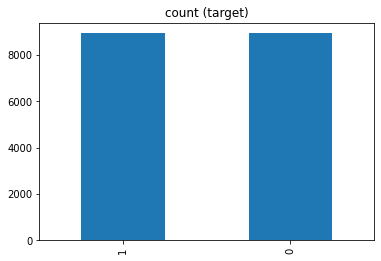

In [ ]:
class_0_under = class_1.sample(class_count_1)

test_under = pd.concat([class_0_under, class_0], axis=0)

print("total class of 1 and0:",test_under['label'].value_counts())# plot the count after under-sampeling
test_under['label'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
test_under = test_under.drop(["num","timestamp","cleaned_timestamp"],axis=1)

In [ ]:
features = test_under.iloc[:,0].values
label = test_under.iloc[:,[1]].values

In [ ]:
#Initialize Count Vectorizer with our custom preprocessing function
word_vector = CountVectorizer(analyzer=processor.process)
#Build Vocab
final_word_vocab = word_vector.fit(features)

In [ ]:
bag_of_words = final_word_vocab.transform(features)
bag_of_words

<17872x32099 sparse matrix of type '<class 'numpy.int64'>'
	with 248636 stored elements in Compressed Sparse Row format>

In [ ]:
#Calculating TF and IDF

tfIdf_obj = TfidfTransformer().fit(bag_of_words)

#Transform data (Calc Weights )
final_feature = tfIdf_obj.transform(bag_of_words)

In [ ]:
class ModelBuilder:
  def __init__(self):
    self.names = [
    "Nearest Neighbors",
    "Linear SVM",
    "Decision Tree",
    "Logistic_Regression"]

    self.classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(max_depth=5),
    LogisticRegression()]


  def split_test_train(self, features,labels,size,state):
    X_train,X_test,y_train,y_test = train_test_split(features,
                                                label,
                                                test_size=size,
                                                random_state=state)
    return (X_train,X_test,y_train,y_test)

  def choose_best_model(self,X_test,X_train,y_test,y_train):
    scores = []
    best_model = self.classifiers[0]
    best_score = 0
    for name, clf in zip(self.names,self.classifiers):
      clf.fit(X_train,y_train)
      score = clf.score(X_test,y_test)
      scores.append(score)
      if score > best_score:
        best_model = clf
        best_score = score
    model_scores_df = pd.DataFrame()
    model_scores_df['Algorithm'] = self.names
    model_scores_df['Score'] = scores

    cm = sns.light_palette('orange',as_cmap=True)
    model_scores = model_scores_df.style.background_gradient(cmap=cm)
    print(f"The model that will perform well with {best_model}")
    return model_scores, best_model

In [ ]:
models = ModelBuilder()
X_test,X_train,y_test,y_train = models.split_test_train(final_feature,label,0.2,6)
scores,model = models.choose_best_model(X_test,X_train,y_test,y_train)
model.fit(X_train,y_train)
scores

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model that will perform well with LogisticRegression()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Algorithm,Score
0,Nearest Neighbors,0.689585
1,Linear SVM,0.543960
2,Decision Tree,0.682521
3,Logistic_Regression,0.756592


In [ ]:
class SentimentAnalyzer:

  def predict(self,model,input):
    """
    Pre Processing
    BOW transformation
    TFIDF transformation

    """
    pre_processed_features = processor.process(input)
    bow_feature = final_word_vocab.transform(pre_processed_features)
    tfIdf_feature = tfIdf_obj.transform(bow_feature)
    return max(set(model.predict(tfIdf_feature)), key = list(model.predict(tfIdf_feature)).count)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

1

In [ ]:
checker = SentimentAnalyzer()
checker.predict(model,"wow,all happy , such a relief thank god")

0

In [ ]:
print(classification_report(y_test,y_pred, target_names=["1","0"]))

              precision    recall  f1-score   support

           1       0.74      0.78      0.76      7152
           0       0.77      0.73      0.75      7145

    accuracy                           0.76     14297
   macro avg       0.76      0.76      0.76     14297
weighted avg       0.76      0.76      0.76     14297



In [ ]:
test_under

,text,label
1853,Rickenbacker is temporarily housing several na...,1
2299,Texans pay surprise visit to Hurricane Harvey...,1
2652,Either I just drove through a forming tornado ...,1
3878,this wildfire smoke is no joke. been wheezing ...,1
1619,my car is in this fucking flood,1
...,...,...
4498,Worried about wildfires? I am too. Help me mit...,0
4533,"Yea, growing food is going to help stop wildfi...",0
4561,You can donate food to families impacted by th...,0
4590,Yumi is donating FREE organic baby food to tho...,0


In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
result

0.7565922920892495